In [76]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

df = pd.read_csv('drive/MyDrive/tripadvisor.csv')
#df = df.drop(['url', 'address', 'phone','rate','votes','approx_cost(for two people)','reviews_list'], axis=1)
#df['dish_liked'] = df['dish_liked'].fillna('')
df = df.fillna('')
#создам признак rate_1 так как колонка rate текстовая
df['rate_1'] = [rate.split('/')[0] for rate in df['rate']]
df['rate_1'] = df['rate_1'].str.replace('NEW','0').str.strip().replace('-', '0').replace('','0').astype(float)
#df['approx_cost(for two people)'].rename({'approx_cost(for two people)':'approx_cost'}, inplace=True)
df.head()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

# чистка строковых колонок
def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)  
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text
    
df['menu_item_clean'] = df['menu_item'].apply(clean_text)
df.menu_item_clean

#объеденил все необходимые колонки датасета для описания ресторана
df['desc'] = df.online_order.map(str) + " " + df.book_table + " " + df.location + " " + df.rest_type + " " + df.dish_liked + " " + df.cuisines + " " + df.menu_item_clean + " " + df['listed_in(type)'] + " " + df['listed_in(city)']
df.desc


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        Yes Yes Banashankari Casual Dining Pasta, Lunc...
1        Yes No Banashankari Casual Dining Momos, Lunch...
2        Yes No Banashankari Cafe, Casual Dining Churro...
3        No No Banashankari Quick Bites Masala Dosa Sou...
4        No No Basavanagudi Casual Dining Panipuri, Gol...
                               ...                        
51712    No No Whitefield Bar  Continental  Pubs and ba...
51713    No No Whitefield Bar  Finger Food  Pubs and ba...
51714    No No Whitefield Bar  Finger Food  Pubs and ba...
51715    No Yes ITPL Main Road, Whitefield Bar Cocktail...
51716    No No ITPL Main Road, Whitefield Bar, Casual D...
Name: desc, Length: 51717, dtype: object

Chicken есть самое распространенное слово. Возможно чаще всего заказывают блюда с курицей


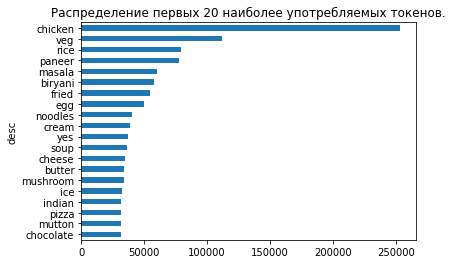

In [54]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
    
common_words = get_top_n_words(df['desc'], 20)
df2 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df2.groupby('desc').sum()['count'].sort_values().plot(kind='barh', title='Распределение первых 20 наиболее употребляемых токенов.',label='123')
print('Chicken есть самое распространенное слово. Возможно чаще всего заказывают блюда с курицей')

Мы видим, что в топ 20 биграмм входят описания либо названия блюд, а также тип кухни, могут быть типы ресторанов


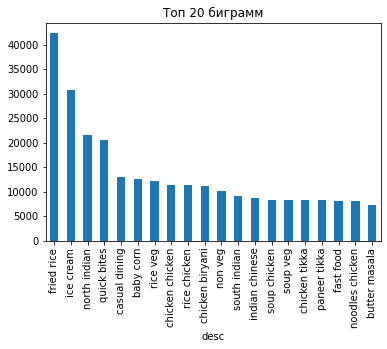

In [55]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['desc'], 20)
df4 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df4.groupby('desc').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Топ 20 биграмм')
print('Мы видим, что в топ 20 биграмм входят описания либо названия блюд, а также тип кухни, могут быть типы ресторанов')

В топ 30 триграмм входит то, что люди заказывают в ресторанах, кафе и тд.Это могут быть токены для названий блюд, типов ресторанов, типов кухни


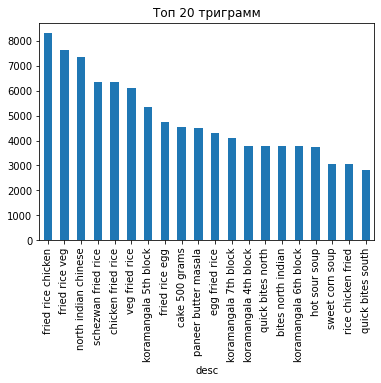

In [56]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['desc'], 20)
df6 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df6.groupby('desc').sum()['count'].sort_values(ascending=False).plot(kind='bar',  title='Топ 20 триграмм')
print('В топ 30 триграмм входит то, что люди заказывают в ресторанах, кафе и тд.Это могут быть токены для названий блюд, типов ресторанов, типов кухни')

In [57]:
print('Статистика триграмм, биграмм и сумка слов говорит о том, что наиболее информативные признаки это тип кухни, название блюда, тип ресторана')

Статистика триграмм, биграмм и сумка слов говорит о том, что наиболее информативные признаки это тип кухни, название блюда, тип ресторана


In [77]:
df['word_count'] = df['desc'].apply(lambda x: len(str(x).split()))
desc_lengths = list(df['word_count'])

print("Количество описаний:",len(desc_lengths),
      "\nСреднее количество слов", np.average(desc_lengths),
      "\nМинимальное количество слов", min(desc_lengths),
      "\nМакссимальное количество слов", max(desc_lengths))

#создаем датасет, где будет описание и название ресторана
df2 = df[['name','desc']]

#проиндексируем колонку name
df.set_index('name', inplace = True)
df2.set_index('name', inplace = True)

#max_features = 50 исользуется для того чтобы колаб не падал. Если использовать все признаки, то не хватает памяти
tf = TfidfVectorizer(max_features=50, analyzer='word', ngram_range=(1, 3), stop_words='english')
# использую первые 20000 строк так как не хватает памяти
tfidf_matrix = tf.fit_transform(df2['desc'][:20000])
#понизить размерности
#TruncatedSVD(n_components=5, random_state=0).fit_transform(tf), не хватает ресурсов компа и коллаба

Количество описаний: 51717 
Среднее количество слов 90.32842198890114 
Минимальное количество слов 4 
Макссимальное количество слов 3903


In [78]:
#косинусное расстояние
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df.index[:20000])

In [113]:
#функция рекомендаций
def recommendations(name, cosine_similarities = cosine_similarities):
    
    recommended = []
    
    # Получить индекс ресторана, который соответствует названию
    idx = indices[indices == name].index[0]

    # Создание серии с оценками сходства в порядке убывания
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)
    #print(score_series.shape)
    #print(score_series)
    # Получение индексов из 20 самых похожих ресторанов, кроме самого себя
    top_20_indexes = list(score_series.iloc[1:21].index)
    #print(top_20_indexes)
    # Заполнение списка именами в топ-20 соответствующих ресторанов. Будем выводить с рейтингом 4 и больше
    for i in top_20_indexes:
        if df.rate_1[i] >=4:
          recommended.append('name: ' + df.index[i] +', ' + ' ' + df['listed_in(type)'][i] + ', ' + df['listed_in(city)'][i] )
        
    return recommended

In [114]:
recommendations('Japan Travel Cafe Azuki')

['name: Japan Travel Cafe Azuki,  Dine-out, Brigade Road',
 'name: Japan Travel Cafe Azuki,  Delivery, Brigade Road',
 'name: Japan Travel Cafe Azuki,  Dine-out, Church Street',
 'name: Japan Travel Cafe Azuki,  Cafes, Church Street',
 'name: Le Cirque Signature - The Leela Palace,  Dine-out, Indiranagar',
 'name: Szechwan Court - The Oberoi,  Dine-out, Brigade Road',
 'name: Japan Travel Cafe Azuki,  Delivery, Church Street',
 'name: White Plate,  Drinks & nightlife, Brigade Road',
 'name: White Plate,  Pubs and bars, Brigade Road',
 'name: White Plate,  Dine-out, Brigade Road',
 'name: Toast & Tonic,  Dine-out, Brigade Road',
 'name: Sakae Japanese Restaurant,  Delivery, Brigade Road',
 'name: Fat Buddha,  Delivery, Brigade Road']

Вывод:
Для создания content-based рекомендаций я использовал информацию об описании ресторанов.Для формирования корпуса данных убрал ненужные признаки, такие как 'url', 'address', 'phone','votes','approx_cost(for two people)','reviews_list'. Из остальных признаков сформировал описание ресторана (колонка desc). Статистика биграмм и триграмм показывает, что наиболее употребляемые сочетания слов это названия блюд, типы ресторанов, типы кухни. Это будут основные информативные признаки. Выбрал TF-IDF векторизацию (так как она придает вес редким словам), посчитал косинунсное расстояние между строками матрицы tfidf. Функция recommendations выводит топ-20 похожих ресторанов( из этих 20 ресторанов отбрасываются с рейтингом < 4).